In [55]:
# load data -- Done
# train model 
# episode update loop
    # seperate data to episods -- Done
    # uncertainty calculation
    # update code

# Parameters

In [56]:
episodes_p =  0.05
seed = 1

# load data

In [57]:
import data_provider as dp
import numpy as np
# load the data
features_all, targets_all   = dp.load_data("./Data/")
data = np.concatenate((features_all,targets_all), axis=1)

In [58]:
# import pandas as pd
# data = pd.read_csv('Data/spambase.csv')
# data = data.sample(frac=1)

In [59]:
from skmultiflow.data import DataStream
stream = DataStream(data)
stream_length = stream.n_remaining_samples()
episode_size = int(stream_length * episodes_p)
stream.restart()
# features_list, targets_list = dp.partition_data(features_all, targets_all, episodes) # old way to make episodes

# initial training

In [60]:
from sklearn.ensemble import RandomForestClassifier
import Uncertainty as unc

# defining the model
model = RandomForestClassifier(max_depth=10, n_estimators=10, random_state=seed)
x_train, y_train = stream.next_sample(episode_size)
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=10, random_state=1)

In [61]:
# set uncertainty score
x_set, y_set = stream.next_sample(episode_size * 2)
tu, eu, au = unc.model_uncertainty(model, x_set, x_train, y_train, laplace_smoothing=1)

tu_set = tu.mean()
score_set = model.score(x_set, y_set)

# Uncertainty detection

In [62]:
# episode loop
update_model = True
updatecounter = 0
episode = 0
stream_score_unc = []
while True:
    # setup new episode
    x_ep, y_ep = stream.next_sample(episode_size)
    if len(y_ep) == 0:
        break
    episode +=1

    stream_score_unc.append(model.score(x_ep, y_ep))

    tu, eu, au = unc.model_uncertainty(model, x_ep, x_train, y_train, laplace_smoothing=1)
    tu_ep = tu.mean()
    if tu_ep > tu_set:
        update_model = True
        print("episode ", episode, "D")
    else:
        print("episode ", episode)

    # train the model / update
    if update_model:
        x_train, y_train = x_ep, y_ep
        model.fit(x_ep, y_ep) # remove keys when fiting the model
        update_model = False
        updatecounter +=1
stream_score_unc

episode  1 D
episode  2 D
episode  3 D
episode  4
episode  5
episode  6
episode  7 D
episode  8
episode  9
episode  10 D
episode  11
episode  12 D
episode  13 D
episode  14
episode  15
episode  16
episode  17
episode  18 D


[0.9,
 0.8913043478260869,
 0.9347826086956522,
 0.9347826086956522,
 0.9043478260869565,
 0.9391304347826087,
 0.9,
 0.9217391304347826,
 0.9173913043478261,
 0.908695652173913,
 0.9043478260869565,
 0.8695652173913043,
 0.9260869565217391,
 0.8478260869565217,
 0.9,
 0.8826086956521739,
 0.8739130434782608,
 1.0]

# Error detection

In [63]:
stream.restart()
_, _ = stream.next_sample(episode_size * 3)

# episode loop
update_model = True
updatecounter_score = 0
episode = 0
stream_score_score = []
while True:
    # setup new episode
    x_ep, y_ep = stream.next_sample(episode_size)
    if len(y_ep) == 0:
        break
    episode +=1

    ep_score = model.score(x_ep, y_ep)
    stream_score_score.append(ep_score)

    if ep_score > score_set:
        update_model = True
        print("episode ", episode, "D")
    else:
        print("episode ", episode)


    # train the model / update
    if update_model:
        x_train, y_train = x_ep, y_ep
        model.fit(x_ep, y_ep) # remove keys when fiting the model
        update_model = False
        updatecounter_score +=1
stream_score_score

episode  1
episode  2
episode  3 D
episode  4 D
episode  5 D
episode  6 D
episode  7
episode  8 D
episode  9
episode  10
episode  11
episode  12
episode  13 D
episode  14
episode  15
episode  16
episode  17
episode  18 D


[0.3782608695652174,
 0.8913043478260869,
 0.9304347826086956,
 0.9347826086956522,
 0.9173913043478261,
 0.9260869565217391,
 0.908695652173913,
 0.9391304347826087,
 0.9,
 0.8956521739130435,
 0.9130434782608695,
 0.8782608695652174,
 0.9391304347826087,
 0.8478260869565217,
 0.9,
 0.8826086956521739,
 0.8739130434782608,
 1.0]

# always update

In [64]:
stream.restart()
_, _ = stream.next_sample(episode_size * 3)

# episode loop
update_model = True
updatecounter_all = 0
episode = 0
stream_score_all = []
while True:
    print("episode ", episode)
    # setup new episode
    x_ep, y_ep = stream.next_sample(episode_size)
    if len(y_ep) == 0:
        break
    episode +=1

    stream_score_all.append(model.score(x_ep, y_ep))

    # train the model / update
    if update_model:
        x_train, y_train = x_ep, y_ep
        model.fit(x_ep, y_ep) # remove keys when fiting the model
        updatecounter_all +=1
stream_score_all

episode  0
episode  1
episode  2
episode  3
episode  4
episode  5
episode  6
episode  7
episode  8
episode  9
episode  10
episode  11
episode  12
episode  13
episode  14
episode  15
episode  16
episode  17
episode  18


[0.3782608695652174,
 0.8913043478260869,
 0.9347826086956522,
 0.9347826086956522,
 0.9173913043478261,
 0.9260869565217391,
 0.908695652173913,
 0.9217391304347826,
 0.9,
 0.9,
 0.9043478260869565,
 0.8478260869565217,
 0.9260869565217391,
 0.8478260869565217,
 0.8956521739130435,
 0.8956521739130435,
 0.8826086956521739,
 1.0]

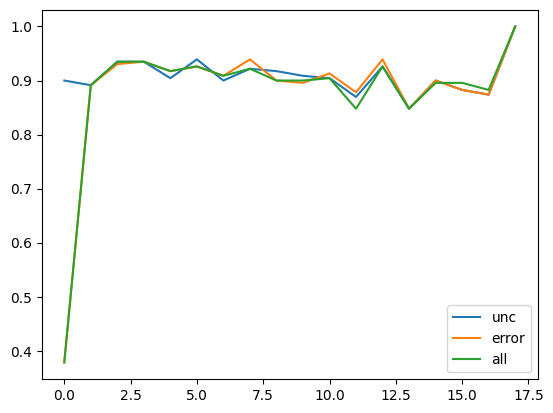

In [65]:
import matplotlib.pyplot as plt

plt.plot(stream_score_unc, label="unc")
plt.plot(stream_score_score, label="error")
plt.plot(stream_score_all, label="all")
plt.legend()
plt.show()